<a href="https://colab.research.google.com/github/Geunju-hub/2022-Samsung-AI-Challenge-3D-Metrology-/blob/main/Dacon_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요 라이브러리 불러오기
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.applications import inception_v3

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import os

In [ ]:
!ls

drive  sample_data  sample_submission.zip  simulation_data  test  train


In [ ]:
# 디렉토리 바꿔주기 -> google drive 안에서 알집 풀기 위함.
!cd /content/drive/MyDrive/Dacon

In [ ]:
!ls

drive  sample_data  sample_submission.zip  simulation_data  test  train


In [ ]:
!unzip -qq /content/drive/MyDrive/Dacon/open.zip
# google 공유 드라이브에 올렸기 때문에 다시 압축해제 할 필요 없음.

replace sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 이미지 전처리 관련한 함수


#log Transform
def getlogtf(img):
  img = img/255.0
  c = 1.0
  img = c * np.log(1 + img)
  img = img * 255
  return img


#Gamma Transform(gamma 인자를 통해 밝기를 얼마나 밝게 할지 설정 가능)
def getgammatf(img,gamma = 3):
  img = img/255.0

  img = img**(1/gamma)

  img = img * 255
  return img

#Fourier Transform, 주의점 : 이미지가 다른 트랜스폼과 다르게 흑백(Grayscale)임, 데이터를 훈련시킬때 1채널로 훈련시켜야함
def getftf(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)
  out = 20*np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
  return out

#CLAHE, 푸리에와 마찬가지로 흑백 스케일임
def getclahe(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
  out = clahe.apply(img)

  return out


def invert(img):
  img = (255-img)
  
  return img

In [ ]:
# 서브폴더별로 맨 앞에 있는 이미지파일 Train_Data로 옮기기

root_dir = './train/SEM'
Train_List = []
Train_Data = []
Y_train_List = [] # 총 train_data의 주소 : 어제 사용했던 y_train의 0번 컬럼처럼 만들기
for (root, dirs, files) in os.walk(root_dir):
  #count = 0
  for name in files:
    #count +=1
    Train_List.append(os.path.join(root, name))
    img = cv2.imread(os.path.join(root,name))
    #img = getgammatf(img,8)
    Train_Data.append(img)
    Y_train_List.append(os.path.join(root,name))
    #if(count==1):
      #break;

In [ ]:
Train_List[0]

'./train/SEM/Depth_140/site_00481/SEM_000135.png'

In [ ]:
# 중복 확인을 위해 set 설정 후 갯수 측정
len(set(Train_List))

60665

In [ ]:
# 숫자 이상한 경우 찾아서 빼주기
for List in Train_List:
  if List.find('.ipynb') != -1:
    idx = Train_List.index(List)
    print(idx)
    print(List)
    Train_List.remove(List)
    Train_Data.pop(idx)
    Y_train_List.pop(idx)

32281
./train/SEM/Depth_140/site_00000/.ipynb_checkpoints/SEM_000165-checkpoint.png


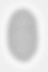

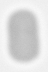

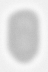

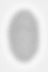

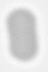

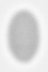

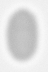

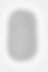

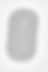

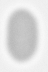

In [ ]:
for i in range(10):
  cv2_imshow(Train_Data[i])

In [ ]:
X_train = np.array(Train_Data)

In [ ]:
X_train.shape

In [ ]:
len(Y_train_List)

In [ ]:
# categorical로 판별하기 위해 숫자 바꿔주기
#labeldict = {0:110, 1:120, 2:130, 3:140}
#reversedict = {110:0, 120:1, 130:2, 140:3}
#y_train = pd.read_csv("./train/average_depth.csv")
#y_train = y_train.sort_values(by="0",ascending = True)
#y_train["target"] = 0
#for i in range(len(y_train)):
#  temp = y_train["0"][i][6:9]
#  temp = int(temp)
#  y_train["target"][i] = reversedict[temp]

#y_train["target"].astype("float")

In [ ]:
df = pd.DataFrame({'0':Y_train_List})

In [ ]:
df['0']

In [ ]:
# labeling 함수 
def labeling(x):
  for depth in ["110", "120", "130", "140"]:
    if x[18:21] == depth:
      x = depth[1]
  return x

In [ ]:
df['label'] = df['0'].apply(labeling)
df['label'] = df['label'].astype('float')
df['label'] -=1

In [ ]:
df['label'].value_counts()

2.0    15166
0.0    15166
3.0    15166
1.0    15166
Name: label, dtype: int64

In [ ]:
# 간단한 모델 구현
model = Sequential()
model.add(Conv2D(32,3, input_shape = (72,48,3)))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(100,activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 70, 46, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25760)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               2576100   
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 2,577,400
Trainable params: 2,577,400
Non-trainable params: 0
____________________________________________

In [ ]:
# loss, optimizer, metrics 정함
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy','RootMeanSquaredError'])

In [ ]:
Y_train = df["label"].values

In [ ]:
#Y_train = y_train["target"].values

In [ ]:
#print(Y_train)

In [ ]:
y_train= tf.keras.utils.to_categorical(Y_train,num_classes = 4)
print(y_train.shape)

(60664, 4)


In [ ]:
type(y_train)

In [ ]:
hist = model.fit(X_train,y_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
1517/1517 [==============================] - 78s 51ms/step - loss: 0.9538 - accuracy: 0.7283 - root_mean_squared_error: 0.3238 - val_loss: 4.4232 - val_accuracy: 0.0671 - val_root_mean_squared_error: 0.6221
Epoch 2/10
1517/1517 [==============================] - 80s 52ms/step - loss: 0.6753 - accuracy: 0.7920 - root_mean_squared_error: 0.2831 - val_loss: 2.2694 - val_accuracy: 0.2899 - val_root_mean_squared_error: 0.5165
Epoch 3/10
1517/1517 [==============================] - 79s 52ms/step - loss: 0.5800 - accuracy: 0.8200 - root_mean_squared_error: 0.2643 - val_loss: 2.0818 - val_accuracy: 0.3175 - val_root_mean_squared_error: 0.5090
Epoch 4/10
1517/1517 [==============================] - 79s 52ms/step - loss: 0.5090 - accuracy: 0.8366 - root_mean_squared_error: 0.2501 - val_loss: 3.1339 - val_accuracy: 0.1472 - val_root_mean_squared_error: 0.5828
Epoch 5/10
1517/1517 [==============================] - 78s 52ms/step - loss: 0.4830 - accuracy: 0.8473 - root_mean_squared_erro

In [ ]:
# accuracy, loss 그래프
def acc_graph(history):  
  acc = history.history['accuracy']                                             # loss = history.history['loss']
  val_acc = history.history['val_accuracy']                                     # val_loss = history.history['val_loss']
 
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Train Accuracy')
  plt.plot(val_acc, label='Val Accuracy')
  plt.text(len(acc)-2, val_acc[-1], f'{val_acc[-1]:.4f}')   # 최종 acc
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])       # [최소, 최대]
  plt.title('Train and Val Accuracy')

  loss = history.history['loss']                                             # loss = history.history['loss']
  val_loss = history.history['val_loss']                                     # val_loss = history.history['val_loss']
 
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Train Loss')
  plt.plot(val_loss, label='Val Loss')
  plt.text(len(loss)-2, val_loss[-1], f'{val_loss[-1]:.4f}')   # 최종 acc
  plt.legend(loc='lower right')
  plt.ylabel('Loss')
  plt.ylim([min(plt.ylim()),max(plt.ylim())])       # [최소, 최대]
  plt.title('Train and Val Loss')

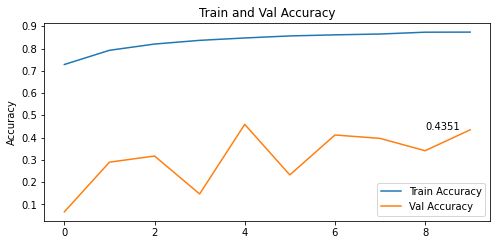

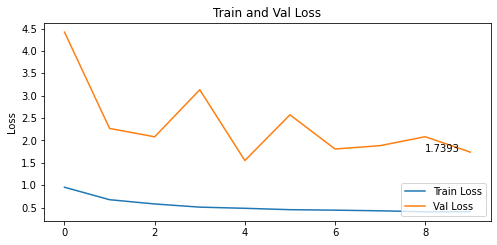

In [ ]:
acc_graph(hist)

In [ ]:
## log_transform으로 전처리된 X_train 학습시키기

#X_train_log = getlogtf(X_train)

#hist_log = model.fit(X_train_log, y_train, epochs = 20, validation_split = 0.2)

#acc_graph(hist_log)

In [ ]:
## gamma_transform으로 전처리된 X_train 학습시키기

#X_train_gamma = getgammatf(X_train)

#hist_gamma = model.fit(X_train_gamma, y_train, epochs = 20, validation_split = 0.2)

#acc_graph(hist_gamma)

In [ ]:
## Fourier_transform으로 전처리된 X_train 학습시키기

#X_train_fourier = getftf(X_train)

#hist_fourier = model.fit(X_train_fourier, y_train, epochs = 20, validation_split = 0.2)

#acc_graph(hist_fourier)

In [ ]:
## Clahe_transform으로 전처리된 X_train 학습시키기

#X_train_clahe = getclahe(X_train)

#hist_clahe = model.fit(X_train_clahe, y_train, epochs = 20, validation_split = 0.2)

#acc_graph(hist_clahe)

### 기본적인 것이 오히려 전처리를 사용한 것보다 성능이 좋지 않아 전이학습을 통한 성능향상으로 방향을 바꾸기로 했다.